In [1]:
import pandas as pd
import numpy as np
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns

# Analyzing cell type differences

In [27]:
df = pd.read_csv('../processed_data/combined_perm_summary.csv')
df.head()

,target_molecule_name,cell_id,clust_id,num_gene_spots,num_cell_spots,observed_periph_score,num_permutations_more_peripheral,permuted_periph_score_Q25,permuted_periph_score_Q50,permuted_periph_score_Q75
0,1700022I11Rik,100024126192764500990464846159908804485,9,1,841,0.048751,57,0.252675,0.494055,0.756837
1,1700022I11Rik,1002898283446010279233117965444068592,2,1,877,0.909920,919,0.253991,0.481756,0.743729
2,1700022I11Rik,100574930949484809578634906420360731463,12,1,1107,0.701897,681,0.261743,0.508582,0.764228
3,1700022I11Rik,10057681216051175595750593230904675495,25,1,1611,0.597765,595,0.252328,0.509621,0.765208
4,1700022I11Rik,100977889601326546072121004031329500681,4,1,821,0.869671,867,0.283496,0.508526,0.760049


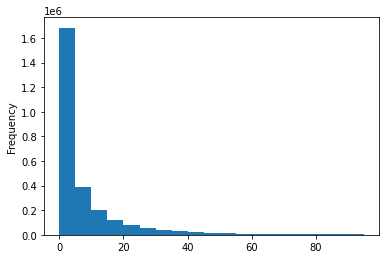

In [28]:
df['num_gene_spots'].plot.hist(bins=np.arange(0,100,5))
plt.show()
plt.close()

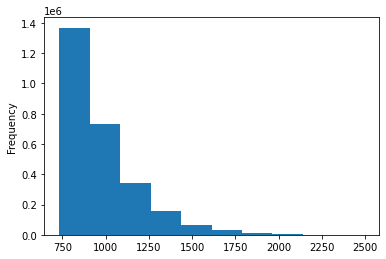

In [30]:
df['num_cell_spots'].plot.hist()
plt.show()
plt.close()

In [69]:
# Ignore cases when there are fewer than 10 spots of the gene
filt_df = df[df['num_gene_spots'].ge(10)]

#Aggregate over cluster/gene pairs
#   Count how many cells in that cluster have that gene
#   For that cluster, calc the median count of the more_extreme_perms
clust_genes = (
    filt_df.groupby(['clust_id','target_molecule_name'])
    ['num_permutations_more_peripheral']
    .agg(
        num_cells = 'count',
        median_more_extreme_permutations = 'median',
    )
).reset_index()

#Filter out clusters that have fewer than 10 cells
clust_genes = clust_genes[clust_genes['num_cells'].ge(10)]


#Filter out genes that have fewer than x clusters
clust_genes = (
    clust_genes.groupby('target_molecule_name')
    .filter(lambda g: g['clust_id'].unique().size >= 4)
)

#Calculate the std of the number of extreme_perms across clusters for each gene
clust_genes['between_clusts_extreme_perms_std'] = (
    clust_genes.groupby('target_molecule_name')
    ['median_more_extreme_permutations']
    .transform('std')
)

print(clust_genes.shape)
clust_genes.sort_values('between_clusts_extreme_perms_std')

(1715, 5)


,clust_id,target_molecule_name,num_cells,median_more_extreme_permutations,between_clusts_extreme_perms_std
3094,30,Col24a1,315,1000.0,3.932768
2555,25,Col24a1,25,1000.0,3.932768
1890,20,Col24a1,45,997.0,3.932768
480,4,Col24a1,176,1000.0,3.932768
2296,23,Col24a1,33,990.0,3.932768
...,...,...,...,...,...
630,5,Cldn5,16,933.0,385.341721
1503,14,Cldn5,10,0.0,385.341721
1245,11,Cldn5,55,563.0,385.341721
1346,12,Cldn5,10,322.0,385.341721


In [78]:
#Sort to show genes that have high between-cluster std
#Flt1 came to the top again!
(
    clust_genes.groupby(['target_molecule_name','between_clusts_extreme_perms_std'])
    ['clust_id'].unique().apply(len)
    .reset_index()
    .rename(columns={'clust_id':'num_clusters'})
    .sort_values(
        'between_clusts_extreme_perms_std',
        ascending=False,
    )
)

,target_molecule_name,between_clusts_extreme_perms_std,num_clusters
31,Cldn5,385.341721,6
149,Unc5b,320.375197,6
51,Flt1,294.925214,9
42,Daam2,280.661591,8
2,Adamts4,276.353940,5
...,...,...,...
56,Gpc6,30.729465,5
77,Nkain3,26.775455,5
39,Ctss,19.383386,14
86,Otof,14.471524,5


In [80]:
clust_genes[clust_genes['target_molecule_name'].eq('Cldn5')]

,clust_id,target_molecule_name,num_cells,median_more_extreme_permutations,between_clusts_extreme_perms_std
630,5,Cldn5,16,933.0,385.341721
696,6,Cldn5,13,2.0,385.341721
1245,11,Cldn5,55,563.0,385.341721
1346,12,Cldn5,10,322.0,385.341721
1503,14,Cldn5,10,0.0,385.341721
2677,26,Cldn5,96,733.5,385.341721


In [81]:
filt_df[filt_df['target_molecule_name'].eq('Cldn5')]

,target_molecule_name,cell_id,clust_id,num_gene_spots,num_cell_spots,observed_periph_score,num_permutations_more_peripheral,permuted_periph_score_Q25,permuted_periph_score_Q50,permuted_periph_score_Q75
575928,Cldn5,100038053095457998072343452615211305922,5,153,926,0.604752,996,0.475162,0.504320,0.529158
575934,Cldn5,100386686732342864546573230234545152080,11,51,1116,0.509857,563,0.449821,0.499104,0.551971
575951,Cldn5,10296386410601799434884500480839509437,30,14,1191,0.397565,189,0.418556,0.504198,0.591940
575963,Cldn5,103992346540181764887952380767613950151,26,40,951,0.460042,303,0.443612,0.497371,0.550079
575967,Cldn5,104223836409382167300953506527947961504,18,10,966,0.173913,4,0.394410,0.497412,0.592650
...,...,...,...,...,...,...,...,...,...,...
579094,Cldn5,92298657807497786761570068455726284081,26,27,976,0.629098,904,0.427254,0.496926,0.567879
579106,Cldn5,94194155471532350639433658067223319504,11,24,1361,0.372520,96,0.429004,0.494306,0.563281
579140,Cldn5,97391262370852335680234852102875242861,26,15,813,0.400984,208,0.420664,0.506765,0.590406
579147,Cldn5,982068894879012186084068465829393400,26,87,1556,0.518638,644,0.461440,0.498072,0.531652


In [ ]:
clu

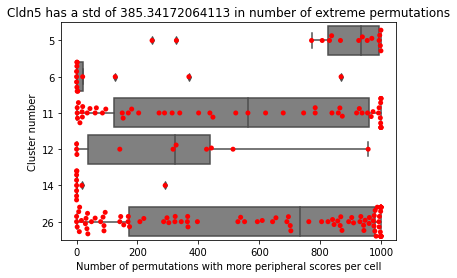

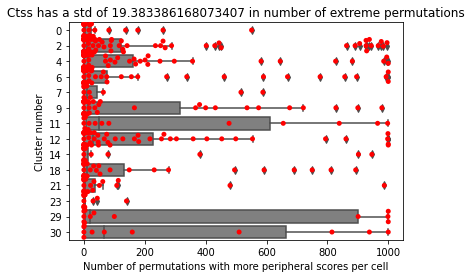

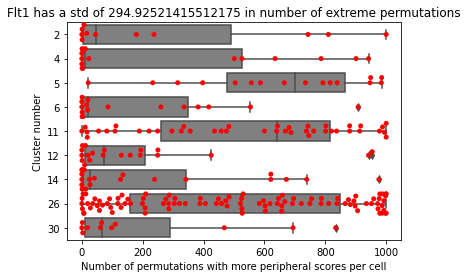

In [94]:

def boxplot_gene(gene):
    filt_clust_ids = clust_genes[clust_genes['target_molecule_name'].eq(gene)]['clust_id']

    std = clust_genes[clust_genes['target_molecule_name'].eq(gene)]['between_clusts_extreme_perms_std'].values[0]
    
    plot_df = (
        filt_df[
            filt_df['target_molecule_name'].eq(gene) &
            filt_df['clust_id'].isin(filt_clust_ids)
        ]       
    )

    sns.boxplot(
        x = 'num_permutations_more_peripheral',
        y = 'clust_id',
        orient = 'h',
        color = 'grey',
        data = plot_df,
    )

    sns.swarmplot(
        x = 'num_permutations_more_peripheral',
        y = 'clust_id',
        orient = 'h',
        color = 'red',
        data = plot_df,
    )

    plt.title('{} has a std of {} in number of extreme permutations'.format(gene,std))
    plt.xlabel('Number of permutations with more peripheral scores per cell')
    plt.ylabel('Cluster number')
    plt.show()
    plt.close()
    
    
boxplot_gene('Cldn5')

boxplot_gene('Ctss')

boxplot_gene('Flt1')

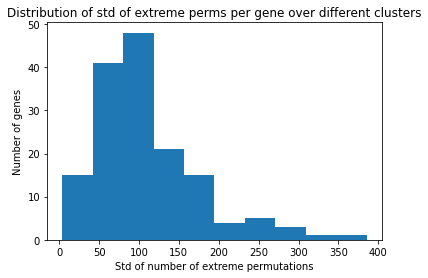

In [98]:
clust_genes.drop_duplicates('target_molecule_name')['between_clusts_extreme_perms_std'].plot.hist()
plt.title('Distribution of std of extreme perms per gene over different clusters')
plt.xlabel('Std of number of extreme permutations')
plt.ylabel('Number of genes')
plt.show()
plt.close()

In [47]:
clust_genes[clust_genes['target_molecule_name'].eq('Ctss')]

,clust_id,target_molecule_name,num_cells,median_more_extreme_permutations
31,0,Ctss,30,5.0
297,2,Ctss,98,10.0
484,4,Ctss,62,13.0
701,6,Ctss,57,5.0
844,7,Ctss,11,10.0
1002,9,Ctss,42,12.5
1254,11,Ctss,14,48.0
1353,12,Ctss,60,29.5
1513,14,Ctss,19,0.0
1757,18,Ctss,34,9.5


,clust_id,target_molecule_name,num_cells,median_more_extreme_permutations,std_num_extreme_perms,between_clusts_extreme_perms_std
1453,12,Teddm3,105,974.0,3.785939,3.785939
2408,23,Teddm3,21,981.0,3.785939,3.785939
2869,27,Teddm3,25,975.0,3.785939,3.785939
1507,14,Col24a1,93,999.0,3.932768,3.932768
1890,20,Col24a1,45,997.0,3.932768,3.932768
...,...,...,...,...,...,...
1346,12,Cldn5,10,322.0,385.341721,385.341721
630,5,Cldn5,16,933.0,385.341721,385.341721
532,4,Npas1,11,34.0,391.172277,391.172277
2348,23,Npas1,282,722.5,391.172277,391.172277


# Sandbox for making the cell/gene perm summaries

In [51]:
gene_cell_df = pd.read_csv('../processed_data/20210127_q90_cell_gene_med_norm_ranks.csv')
gene_cell_df = gene_cell_df.set_index(['cell_id','target_molecule_name'])
gene_cell_df.head()

normalized_rank  \
cell_id                                 target_molecule_name                    
100024126192764500990464846159908804485 1700022I11Rik                0.048751   
                                        Acta2                        0.894768   
                                        Adam2                        0.752675   
                                        Adamts4                      0.859691   
                                        Adra1b                       0.325208   

                                                              clust_id  
cell_id                                 target_molecule_name            
100024126192764500990464846159908804485 1700022I11Rik                9  
                                        Acta2                        9  
                                        Adam2                        9  
                                        Adamts4                      9  
                                        Adra1b                       9

In [58]:
gene_cell_df = pd.read_csv('../processed_data/20210127_q90_cell_gene_med_norm_ranks.csv')

In [93]:
f_paths = glob.glob('/scratch/PI/horence/rob/isoform_localizations/perm_by_gene/*.csv')

for i,f_path in enumerate(f_paths):
    gene_name = os.path.basename(f_path).split('_')[-1].split('.')[0]
    
    perm_tab = pd.read_csv(f_path, index_col=0)
    
    gene_summary_info = (
        gene_cell_df[
            gene_cell_df[
                'target_molecule_name'].eq(gene_name)
        ].set_index('cell_id')
    )
    
    perm_summary = pd.DataFrame({
        'num_more_extreme_perms':perm_tab.sub(
            gene_summary_info['normalized_rank'],axis=0
        ).lt(0).sum(axis=1),
        'Q25_perm':perm_tab.quantile(0.25, axis=1),
        'Q50_perm':perm_tab.quantile(0.50, axis=1),
        'Q75_perm':perm_tab.quantile(0.75, axis=1),
    })

    collected_info = pd.concat((perm_summary,gene_summary_info),axis=1)
    collected_info.to_csv('/scratch/PI/horence/rob/isoform_localizations/perm_by_gene/{}_collected.csv'.format(gene_name))
    break

In [94]:
x = pd.read_csv('/scratch/PI/horence/rob/isoform_localizations/perm_by_gene/Cd24a_collected.csv')
x.head()


,cell_id,num_more_extreme_perms,Q25_perm,Q50_perm,Q75_perm,target_molecule_name,normalized_rank,clust_id
0,100024126192764500990464846159908804485,846,0.317479,0.485137,0.656361,Cd24a,0.725327,9
1,100070027782195876079415879748834848836,934,0.268373,0.488554,0.730120,Cd24a,0.936145,9
2,100102359956566417117615107711222572060,1000,0.352287,0.491768,0.640854,Cd24a,0.981707,12
3,100103011697713173197099481662394607724,795,0.340293,0.516811,0.668384,Cd24a,0.711497,30
4,100120630789554574689109334609716249164,389,0.255034,0.495973,0.754362,Cd24a,0.382550,14


In [ ]:
perm_tab

In [89]:
perm_tab.loc['100102359956566417117615107711222572060']

0      0.656707
1      0.587195
2      0.599390
3      0.215854
4      0.754878
         ...   
995    0.516463
996    0.437805
997    0.843293
998    0.785976
999    0.321951
Name: 100102359956566417117615107711222572060, Length: 1000, dtype: float64

In [90]:
gene_summary_info.loc['100102359956566417117615107711222572060']

target_molecule_name       Cd24a
normalized_rank         0.981707
clust_id                      12
Name: 100102359956566417117615107711222572060, dtype: object

100024126192764500990464846159908804485     846
100070027782195876079415879748834848836     934
100102359956566417117615107711222572060    1000
100103011697713173197099481662394607724     795
100120630789554574689109334609716249164     389
                                           ... 
99908647760626017793308403143483877274      501
99962729114062153927784338888318171597        9
99969166454721663399298872433695962292      771
99985816691327783828891364793469425625      142
99997470167777465101376150817407669505      841
Length: 16672, dtype: int64

In [82]:
perm_tab

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
222731768422977059900227969363435857833,0.693273,0.692132,0.533637,0.147092,0.012543,0.396807,0.299886,0.298746,0.633979,0.371722,...,0.353478,0.668187,0.714937,0.131129,0.297605,0.652223,0.974914,0.115165,0.450399,0.354618
50895563111589999445359623445409082636,0.717089,0.472152,0.495570,0.550633,0.673418,0.627215,0.762025,0.824051,0.182278,0.796835,...,0.493038,0.517722,0.650000,0.694304,0.731013,0.605696,0.628481,0.481013,0.583544,0.590506
236544133250884027596792000693618583801,0.390515,0.235116,0.789102,0.744702,0.853683,0.903128,0.247225,0.052472,0.376387,0.728557,...,0.106963,0.936428,0.974773,0.088799,0.647830,0.906155,0.226034,0.840565,0.726539,0.151362
331521026655800010206889807963799816539,0.363737,0.093437,0.644049,0.612903,0.116796,0.035595,0.988877,0.802002,0.664071,0.658509,...,0.088988,0.204672,0.242492,0.902113,0.309232,0.636263,0.783092,0.953281,0.006674,0.244716
70362899224714468667476564221909416293,0.732290,0.048600,0.449753,0.548600,0.191928,0.789951,0.524712,0.231466,0.032949,0.415157,...,0.864909,0.821252,0.327842,0.396211,0.288303,0.901977,0.021417,0.221582,0.931631,0.957166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26183749334613212664534842416095700546,0.482593,0.611044,0.402761,0.163866,0.566026,0.509604,0.501200,0.372149,0.464586,0.577431,...,0.385954,0.372149,0.497599,0.609244,0.337335,0.083433,0.828932,0.350540,0.565426,0.532413
95680371955165450489454698595820295454,0.534594,0.334871,0.470480,0.506919,0.558118,0.709871,0.207565,0.351937,0.426661,0.446494,...,0.369926,0.640683,0.284133,0.779520,0.222786,0.547970,0.253229,0.479244,0.406827,0.455258
82177488754776148507785835876947915664,0.461444,0.395349,0.343941,0.252142,0.995104,0.033048,0.077111,0.906977,0.474908,0.070991,...,0.388005,0.843329,0.088127,0.320685,0.685435,0.553244,0.052632,0.828641,0.029376,0.804162
227747800804126471890839008344571017434,0.406283,0.223560,0.616230,0.730890,0.447644,0.397382,0.365445,0.315183,0.501047,0.470681,...,0.575916,0.499476,0.601047,0.572251,0.448691,0.757068,0.695288,0.484817,0.740314,0.396859


In [92]:
perm_summary = pd.DataFrame({
    'num_more_extreme_perms':perm_tab.sub(
        gene_summary_info['normalized_rank'],axis=0
    ).lt(0).sum(axis=1),
    'Q25_perm':perm_tab.quantile(0.25, axis=1),
    'Q50_perm':perm_tab.quantile(0.50, axis=1),
    'Q75_perm':perm_tab.quantile(0.75, axis=1),
})

pd.concat((perm_summary,gene_summary_info),axis=1)

,num_more_extreme_perms,Q25,Q50,Q75,target_molecule_name,normalized_rank,clust_id
cell_id,,,,,,,
100024126192764500990464846159908804485,846,0.317479,0.485137,0.656361,Cd24a,0.725327,9
100070027782195876079415879748834848836,934,0.268373,0.488554,0.730120,Cd24a,0.936145,9
100102359956566417117615107711222572060,1000,0.352287,0.491768,0.640854,Cd24a,0.981707,12
100103011697713173197099481662394607724,795,0.340293,0.516811,0.668384,Cd24a,0.711497,30
100120630789554574689109334609716249164,389,0.255034,0.495973,0.754362,Cd24a,0.382550,14
...,...,...,...,...,...,...,...
99908647760626017793308403143483877274,501,0.317269,0.501339,0.678715,Cd24a,0.503347,2
99962729114062153927784338888318171597,9,0.245198,0.483051,0.740113,Cd24a,0.010169,6
99969166454721663399298872433695962292,771,0.236607,0.504464,0.746652,Cd24a,0.771205,23


In [70]:
pd.concat((perm_tab,gene_summary_info),axis=1)

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,target_molecule_name,normalized_rank,clust_id
222731768422977059900227969363435857833,0.693273,0.692132,0.533637,0.147092,0.012543,0.396807,0.299886,0.298746,0.633979,0.371722,...,0.131129,0.297605,0.652223,0.974914,0.115165,0.450399,0.354618,Cd24a,0.374002,2
50895563111589999445359623445409082636,0.717089,0.472152,0.495570,0.550633,0.673418,0.627215,0.762025,0.824051,0.182278,0.796835,...,0.694304,0.731013,0.605696,0.628481,0.481013,0.583544,0.590506,Cd24a,0.622785,2
236544133250884027596792000693618583801,0.390515,0.235116,0.789102,0.744702,0.853683,0.903128,0.247225,0.052472,0.376387,0.728557,...,0.088799,0.647830,0.906155,0.226034,0.840565,0.726539,0.151362,Cd24a,0.800202,2
331521026655800010206889807963799816539,0.363737,0.093437,0.644049,0.612903,0.116796,0.035595,0.988877,0.802002,0.664071,0.658509,...,0.902113,0.309232,0.636263,0.783092,0.953281,0.006674,0.244716,Cd24a,0.595106,2
70362899224714468667476564221909416293,0.732290,0.048600,0.449753,0.548600,0.191928,0.789951,0.524712,0.231466,0.032949,0.415157,...,0.396211,0.288303,0.901977,0.021417,0.221582,0.931631,0.957166,Cd24a,0.866557,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26183749334613212664534842416095700546,0.482593,0.611044,0.402761,0.163866,0.566026,0.509604,0.501200,0.372149,0.464586,0.577431,...,0.609244,0.337335,0.083433,0.828932,0.350540,0.565426,0.532413,Cd24a,0.424370,4
95680371955165450489454698595820295454,0.534594,0.334871,0.470480,0.506919,0.558118,0.709871,0.207565,0.351937,0.426661,0.446494,...,0.779520,0.222786,0.547970,0.253229,0.479244,0.406827,0.455258,Cd24a,0.695572,20
82177488754776148507785835876947915664,0.461444,0.395349,0.343941,0.252142,0.995104,0.033048,0.077111,0.906977,0.474908,0.070991,...,0.320685,0.685435,0.553244,0.052632,0.828641,0.029376,0.804162,Cd24a,0.293758,4
227747800804126471890839008344571017434,0.406283,0.223560,0.616230,0.730890,0.447644,0.397382,0.365445,0.315183,0.501047,0.470681,...,0.572251,0.448691,0.757068,0.695288,0.484817,0.740314,0.396859,Cd24a,0.378534,29


In [65]:
gene_summary_info

,target_molecule_name,normalized_rank,clust_id
cell_id,,,
100024126192764500990464846159908804485,Cd24a,0.725327,9
100070027782195876079415879748834848836,Cd24a,0.936145,9
100102359956566417117615107711222572060,Cd24a,0.981707,12
100103011697713173197099481662394607724,Cd24a,0.711497,30
100120630789554574689109334609716249164,Cd24a,0.382550,14
...,...,...,...
99908647760626017793308403143483877274,Cd24a,0.503347,2
99962729114062153927784338888318171597,Cd24a,0.010169,6
99969166454721663399298872433695962292,Cd24a,0.771205,23


In [67]:
perm_tab

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
222731768422977059900227969363435857833,0.693273,0.692132,0.533637,0.147092,0.012543,0.396807,0.299886,0.298746,0.633979,0.371722,...,0.353478,0.668187,0.714937,0.131129,0.297605,0.652223,0.974914,0.115165,0.450399,0.354618
50895563111589999445359623445409082636,0.717089,0.472152,0.495570,0.550633,0.673418,0.627215,0.762025,0.824051,0.182278,0.796835,...,0.493038,0.517722,0.650000,0.694304,0.731013,0.605696,0.628481,0.481013,0.583544,0.590506
236544133250884027596792000693618583801,0.390515,0.235116,0.789102,0.744702,0.853683,0.903128,0.247225,0.052472,0.376387,0.728557,...,0.106963,0.936428,0.974773,0.088799,0.647830,0.906155,0.226034,0.840565,0.726539,0.151362
331521026655800010206889807963799816539,0.363737,0.093437,0.644049,0.612903,0.116796,0.035595,0.988877,0.802002,0.664071,0.658509,...,0.088988,0.204672,0.242492,0.902113,0.309232,0.636263,0.783092,0.953281,0.006674,0.244716
70362899224714468667476564221909416293,0.732290,0.048600,0.449753,0.548600,0.191928,0.789951,0.524712,0.231466,0.032949,0.415157,...,0.864909,0.821252,0.327842,0.396211,0.288303,0.901977,0.021417,0.221582,0.931631,0.957166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26183749334613212664534842416095700546,0.482593,0.611044,0.402761,0.163866,0.566026,0.509604,0.501200,0.372149,0.464586,0.577431,...,0.385954,0.372149,0.497599,0.609244,0.337335,0.083433,0.828932,0.350540,0.565426,0.532413
95680371955165450489454698595820295454,0.534594,0.334871,0.470480,0.506919,0.558118,0.709871,0.207565,0.351937,0.426661,0.446494,...,0.369926,0.640683,0.284133,0.779520,0.222786,0.547970,0.253229,0.479244,0.406827,0.455258
82177488754776148507785835876947915664,0.461444,0.395349,0.343941,0.252142,0.995104,0.033048,0.077111,0.906977,0.474908,0.070991,...,0.388005,0.843329,0.088127,0.320685,0.685435,0.553244,0.052632,0.828641,0.029376,0.804162
227747800804126471890839008344571017434,0.406283,0.223560,0.616230,0.730890,0.447644,0.397382,0.365445,0.315183,0.501047,0.470681,...,0.575916,0.499476,0.601047,0.572251,0.448691,0.757068,0.695288,0.484817,0.740314,0.396859


In [61]:
perm_tab.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
222731768422977059900227969363435857833,0.693273,0.692132,0.533637,0.147092,0.012543,0.396807,0.299886,0.298746,0.633979,0.371722,...,0.353478,0.668187,0.714937,0.131129,0.297605,0.652223,0.974914,0.115165,0.450399,0.354618
50895563111589999445359623445409082636,0.717089,0.472152,0.495570,0.550633,0.673418,0.627215,0.762025,0.824051,0.182278,0.796835,...,0.493038,0.517722,0.650000,0.694304,0.731013,0.605696,0.628481,0.481013,0.583544,0.590506
236544133250884027596792000693618583801,0.390515,0.235116,0.789102,0.744702,0.853683,0.903128,0.247225,0.052472,0.376387,0.728557,...,0.106963,0.936428,0.974773,0.088799,0.647830,0.906155,0.226034,0.840565,0.726539,0.151362
331521026655800010206889807963799816539,0.363737,0.093437,0.644049,0.612903,0.116796,0.035595,0.988877,0.802002,0.664071,0.658509,...,0.088988,0.204672,0.242492,0.902113,0.309232,0.636263,0.783092,0.953281,0.006674,0.244716
70362899224714468667476564221909416293,0.732290,0.048600,0.449753,0.548600,0.191928,0.789951,0.524712,0.231466,0.032949,0.415157,...,0.864909,0.821252,0.327842,0.396211,0.288303,0.901977,0.021417,0.221582,0.931631,0.957166


In [57]:
f_paths = glob.glob('/scratch/PI/horence/rob/isoform_localizations/perm_by_gene/*.csv')

per_cell_data = {
    'gene':[],
    'cell':[],
    'med_over_perm':[],
    'num_perms':[],
}

per_perm_data = {
    'gene':[],
    'num_cells':[],
    'num_cell_perms_':[],
}


for i,f_path in enumerate(f_paths):
    gene_name = os.path.basename(f_path).split('_')[-1].split('.')[0]
    print(gene_name)
    print(f_path)
    
    perm_tab = pd.read_csv(f_path, index_col=0)
    perm_tab['target_molecule_name'] = gene_name
    
    perm_tab = (
        perm_tab.reset_index()
        .rename(columns={'index':'cell_id'})
        .set_index(['cell_id','target_molecule_name'])
    )
    
    gene_cell_df['Q25_perms'] = perm_tab.quantile(0.25, axis=1)
    gene_cell_df['Q50_perms'] = perm_tab.quantile(0.50, axis=1)
    gene_cell_df['Q75_perms'] = perm_tab.quantile(0.75, axis=1)
    
    #sloppy, but counts the number of permutations less-than (more extreme) the obs per-cell median value
    perm_tab['obs_med'] = gene_cell_df['normalized_rank']
    gene_cell_df['num_more_extreme_perms'] = (
        perm_tab.sub(
            perm_tab['obs_med'],axis=0
        )
        .lt(0)
        .sum(axis=1)
        .astype(int)
    )
    print(gene_cell_df[gene_cell_df['Q25_perms'].notnull()].reset_index()['target_molecule_name'].unique())
    
    if i > 2:
        break

#gene_cell_df.reset_index().to_csv('../processed_data/20210128_gene_cell_permutation_summary.csv',index=False)

Cd24a
/scratch/PI/horence/rob/isoform_localizations/perm_by_gene/test_perms_matrix_Cd24a.csv
['Cd24a']
Nr4a1
/scratch/PI/horence/rob/isoform_localizations/perm_by_gene/test_perms_matrix_Nr4a1.csv
['Nr4a1']
Prdm8
/scratch/PI/horence/rob/isoform_localizations/perm_by_gene/test_perms_matrix_Prdm8.csv


KeyboardInterrupt: 

In [55]:
perm_tab.head()

,,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,obs_med
cell_id,target_molecule_name,,,,,,,,,,,,,,,,,,,,,
70362899224714468667476564221909416293,Chrm2,0.636738,0.312191,0.373970,0.556425,0.478171,0.571252,0.557661,0.421746,0.672570,0.398682,...,0.449753,0.604613,0.592669,0.465815,0.259473,0.315074,0.564250,0.245470,0.498353,0.304778
217951229059897556843731256135790480948,Chrm2,0.446656,0.158439,0.350318,0.228503,0.417994,0.737261,0.214968,0.642516,0.382166,0.548567,...,0.698248,0.206210,0.551752,0.703822,0.679936,0.197452,0.485669,0.414013,0.359076,0.667197
222731768422977059900227969363435857833,Chrm2,0.092360,0.557583,0.218928,0.109464,0.966933,0.374002,0.880274,0.651083,0.339795,0.867731,...,0.208666,0.725200,0.657925,0.903079,0.486887,0.507412,0.933865,0.459521,0.460661,0.850627
157049678893679680426906688425474877404,Chrm2,0.730457,0.555838,0.743655,0.428934,0.683249,0.570558,0.737563,0.652792,0.428934,0.289340,...,0.676650,0.459898,0.624365,0.408629,0.411168,0.494924,0.492893,0.489340,0.645685,0.702538
162985633052267113558515575704877440230,Chrm2,0.587259,0.620450,0.441113,0.617238,0.731263,0.533191,0.613490,0.815310,0.246253,0.594218,...,0.306745,0.652034,0.657388,0.455032,0.680942,0.338865,0.480193,0.381692,0.801927,0.679336


In [56]:
gene_cell_df[gene_cell_df['Q25_perms'].notnull()]

,,normalized_rank,clust_id,Q25_perms,Q50_perms,Q75_perms,num_more_extreme_perms
cell_id,target_molecule_name,,,,,,
100024126192764500990464846159908804485,Chrm2,0.727705,9,0.358799,0.507432,0.655321,848.0
100042292675978612289781789372249900646,Chrm2,0.471866,4,0.424482,0.499506,0.584403,396.0
100066386586660919794878665136894625703,Chrm2,0.659429,12,0.246571,0.503429,0.736286,668.0
100070027782195876079415879748834848836,Chrm2,0.495181,9,0.382831,0.502410,0.615964,486.0
100103011697713173197099481662394607724,Chrm2,0.343818,30,0.409707,0.495662,0.583785,118.0
...,...,...,...,...,...,...,...
99868645014449598813706550007068817959,Chrm2,0.016949,22,0.266667,0.497175,0.742373,20.0
9987130014843835551235836717246466396,Chrm2,0.453441,4,0.414136,0.504049,0.585020,336.0
99908647760626017793308403143483877274,Chrm2,0.808568,2,0.253012,0.503347,0.759036,807.0


In [47]:
gene_cell_df['Q25_perms'] = perm_tab.quantile(0.25, axis=1)

In [44]:
f_path

'/scratch/PI/horence/rob/isoform_localizations/perm_by_gene/test_perms_matrix_Chrm2.csv'

In [49]:
p = gene_cell_df.reset_index()
p[p['Q25_perms'].notnull()]['target_molecule_name'].unique()

array(['Chrm2'], dtype=object)

In [30]:
gene_cell_df[gene_cell_df['Q25_over_perms'].notnull()]

,,normalized_rank,clust_id,Q25_over_perms,Q50_over_perms,Q75_over_perms,num_more_extreme_perms
cell_id,target_molecule_name,,,,,,
100024126192764500990464846159908804485,Cd24a,0.725327,9,0.317479,0.317479,0.317479,846.0
100070027782195876079415879748834848836,Cd24a,0.936145,9,0.268373,0.268373,0.268373,934.0
100102359956566417117615107711222572060,Cd24a,0.981707,12,0.352287,0.352287,0.352287,1000.0
100103011697713173197099481662394607724,Cd24a,0.711497,30,0.340293,0.340293,0.340293,795.0
100120630789554574689109334609716249164,Cd24a,0.382550,14,0.255034,0.255034,0.255034,389.0
...,...,...,...,...,...,...,...
99908647760626017793308403143483877274,Cd24a,0.503347,2,0.317269,0.317269,0.317269,501.0
99962729114062153927784338888318171597,Cd24a,0.010169,6,0.245198,0.245198,0.245198,9.0
99969166454721663399298872433695962292,Cd24a,0.771205,23,0.236607,0.236607,0.236607,771.0


# 

In [99]:
perm_df = pd.read_csv('/scratch/PI/horence/rob/isoform_localizations/perm_by_gene/test_perms_matrix_Col14a1.csv',index_col=0)
perm_df.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
331521026655800010206889807963799816539,0.480534,0.216908,0.561735,0.799778,0.723026,0.560623,0.424917,0.641824,0.131257,0.862069,...,0.903226,0.559511,0.763070,0.213571,0.542825,0.521691,0.233593,0.893215,0.685206,0.270300
70362899224714468667476564221909416293,0.252059,0.879736,0.398682,0.415157,0.647446,0.457166,0.789127,0.996705,0.266886,0.186985,...,0.848435,0.822076,0.845964,0.349259,0.999176,0.136738,0.591433,0.764415,0.374794,0.473641
236544133250884027596792000693618583801,0.149344,0.574168,0.889001,0.987891,0.824420,0.592331,0.484359,0.120081,0.844601,0.916246,...,0.568113,0.948537,0.149344,0.967709,0.231080,0.518668,0.784057,0.352170,0.232089,0.961655
157049678893679680426906688425474877404,0.513198,0.644162,0.647208,0.432995,0.863959,0.625381,0.373096,0.460406,0.819289,0.403553,...,0.554822,0.493401,0.303553,0.562944,0.292893,0.741117,0.586802,0.520305,0.664975,0.455838
323645512235493944014858055919787989384,0.333333,0.125553,0.682582,0.610080,0.955791,0.500442,0.030946,0.137931,0.452697,0.419982,...,0.793988,0.425287,0.621574,0.903625,0.638373,0.024757,0.587091,0.579134,0.603006,0.191866


In [100]:
perm_df.quantile(0.25)

0      0.284777
1      0.288745
2      0.278177
3      0.284494
4      0.278195
         ...   
995    0.283245
996    0.274536
997    0.283178
998    0.281791
999    0.283257
Name: 0.25, Length: 1000, dtype: float64

In [2]:
f_path = 'test_perms_matrix_Hs3st5.csv'

full_path = os.path.join('/scratch/PI/horence/rob/isoform_localizations/perm_by_gene',f_path)
gene_cell_df = pd.read_csv('../processed_data/20210127_q90_cell_gene_med_norm_ranks.csv')
gene_name = os.path.basename(full_path).split('_')[-1].split('.')[0]

perm_tab = pd.read_csv(full_path, index_col=0)

gene_summary_info = (
    gene_cell_df[
        gene_cell_df[
            'target_molecule_name'].eq(gene_name)
    ].set_index('cell_id')
)

In [22]:
f_paths = glob.glob('/scratch/PI/horence/rob/isoform_localizations/perm_by_gene/*perms_over_cells*')
x = pd.concat([pd.read_csv(f).T for f in f_paths],axis=1)
x

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
gene,Cldn5,Col24a1,Blank-9,Camk2d,Plcxd3,Ankfn1,Blank-8,C1qtnf7,Egr2,Ikzf2,...,Marcksl1,Dscaml1,Vtn,Slc44a5,Tmtc2,Ccnb1,Cacng5,Blank-3,Fam84b,Fezf2
num_cells,3238,6403,4251,19781,14157,5514,5270,1938,10508,10379,...,13290,19984,7076,9060,15638,4087,8732,3975,12811,13034
real_Q25,0.109027,0.621071,0.357121,0.382998,0.34375,0.383723,0.309889,0.323393,0.439124,0.381283,...,0.29707,0.396678,0.226887,0.404934,0.348687,0.338986,0.323808,0.414308,0.345384,0.380055
real_Q50,0.345253,0.805838,0.621622,0.480506,0.492739,0.587525,0.557525,0.596202,0.65984,0.602165,...,0.429504,0.513833,0.477407,0.621212,0.54459,0.599781,0.512613,0.659731,0.516213,0.5
real_Q75,0.660303,0.905948,0.831739,0.575935,0.636757,0.789254,0.795863,0.833018,0.832745,0.798409,...,0.547651,0.627884,0.720179,0.807268,0.72362,0.820092,0.701991,0.854632,0.673526,0.613082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
clust_19_lt_count_Q50,NaN,NaN,NaN,325,319,118,NaN,NaN,NaN,NaN,...,31,616,NaN,NaN,559,NaN,608,NaN,449,244
clust_19_lt_count_Q75,NaN,NaN,NaN,325,319,118,NaN,NaN,NaN,NaN,...,31,616,NaN,NaN,559,NaN,608,NaN,449,244
clust_19_Q25,NaN,NaN,NaN,0.502949,0.507864,0.551769,NaN,NaN,NaN,NaN,...,0.499345,0.486239,NaN,NaN,0.491481,NaN,0.498034,NaN,0.496723,0.494758
clust_19_Q50,NaN,NaN,NaN,0.502949,0.507864,0.551769,NaN,NaN,NaN,NaN,...,0.499345,0.486239,NaN,NaN,0.491481,NaN,0.498034,NaN,0.496723,0.494758


In [23]:
x.reset_index().to_csv('/oak/stanford/groups/horence/rob/isoform_localizations/processed_data/20210128_combined_perm_over_cells.csv',header=None,index=None)

In [24]:
q = pd.read_csv('/oak/stanford/groups/horence/rob/isoform_localizations/processed_data/20210128_combined_perm_over_cells.csv')
q.head(60)

,gene,Cldn5,Col24a1,Blank-9,Camk2d,Plcxd3,Ankfn1,Blank-8,C1qtnf7,Egr2,...,Marcksl1,Dscaml1,Vtn,Slc44a5,Tmtc2,Ccnb1,Cacng5,Blank-3,Fam84b,Fezf2
0,num_cells,3238.000000,6403.000000,4251.000000,19781.000000,14157.000000,5514.000000,5270.000000,1938.000000,10508.000000,...,13290.000000,19984.000000,7076.000000,9060.000000,15638.000000,4087.000000,8732.000000,3975.000000,12811.000000,13034.000000
1,real_Q25,0.109027,0.621071,0.357121,0.382998,0.343750,0.383723,0.309889,0.323393,0.439124,...,0.297070,0.396678,0.226887,0.404934,0.348687,0.338986,0.323808,0.414308,0.345384,0.380055
2,real_Q50,0.345253,0.805838,0.621622,0.480506,0.492739,0.587525,0.557525,0.596202,0.659840,...,0.429504,0.513833,0.477407,0.621212,0.544590,0.599781,0.512613,0.659731,0.516213,0.500000
3,real_Q75,0.660303,0.905948,0.831739,0.575935,0.636757,0.789254,0.795863,0.833018,0.832745,...,0.547651,0.627884,0.720179,0.807268,0.723620,0.820092,0.701991,0.854632,0.673526,0.613082
4,overall_clusts_lt_count_Q25,0.000000,1000.000000,1000.000000,0.000000,0.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,0.000000,431.000000,0.000000,1000.000000,1000.000000,1000.000000,47.000000,1000.000000,121.000000,0.000000
5,overall_clusts_lt_count_Q50,0.000000,1000.000000,1000.000000,0.000000,1.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,0.000000,1000.000000,0.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,574.000000
6,overall_clusts_lt_count_Q75,0.000000,1000.000000,1000.000000,0.000000,59.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,0.000000,1000.000000,878.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
7,overall_clusts_Q25,0.306325,0.323705,0.262918,0.409314,0.357920,0.304409,0.266667,0.263368,0.296028,...,0.382246,0.396938,0.284251,0.290672,0.324684,0.264222,0.330335,0.261452,0.348878,0.392960
8,overall_clusts_Q50,0.499831,0.499397,0.499337,0.499454,0.499444,0.499492,0.499456,0.499094,0.499483,...,0.499443,0.499424,0.499371,0.499584,0.499439,0.499363,0.499362,0.499488,0.499401,0.499421
9,overall_clusts_Q75,0.693521,0.675096,0.735154,0.589642,0.640853,0.694633,0.732275,0.736197,0.703259,...,0.616726,0.601899,0.714459,0.708845,0.674421,0.734488,0.668486,0.737385,0.650104,0.605999


In [128]:
overall_Q25 = gene_summary_info['normalized_rank'].quantile(0.25)
overall_Q50 = gene_summary_info['normalized_rank'].quantile(0.50)
overall_Q75 = gene_summary_info['normalized_rank'].quantile(0.75)

ret_df = pd.DataFrame({'gene':[gene_name]})
ret_df['overall_clusts_lt_Q25'] = (perm_tab.quantile(0.25) < overall_Q25).sum()
ret_df['overall_clusts_lt_Q50'] = (perm_tab.quantile(0.50) < overall_Q50).sum()
ret_df['overall_clusts_lt_Q75'] = (perm_tab.quantile(0.75) < overall_Q75).sum()


for clust_id,g in gene_summary_info.groupby('clust_id'):
    clust_Q25 = g['normalized_rank'].quantile(0.25)
    clust_Q50 = g['normalized_rank'].quantile(0.50)
    clust_Q75 = g['normalized_rank'].quantile(0.75)
    
    ret_df['clust_{}_lt_Q25'.format(clust_id)] = (perm_tab.loc[g.index].quantile(0.25) < clust_Q25).sum()
    ret_df['clust_{}_lt_Q50'.format(clust_id)] = (perm_tab.loc[g.index].quantile(0.50) < clust_Q50).sum()
    ret_df['clust_{}_lt_Q75'.format(clust_id)] = (perm_tab.loc[g.index].quantile(0.75) < clust_Q75).sum()
    
ret_df.to_csv(
    '/scratch/PI/horence/rob/isoform_localizations/perm_by_gene/{}_perms_over_cells.csv'.format(gene_name),
    index=False,
)

In [127]:
gene_name

'Hs3st5'

In [118]:
(perm_tab.loc[g.index].quantile(0.25) < clust_Q25).sum()

829

In [112]:
ret_df.shape

(1000, 90)

0      0.496443
1      0.480149
2      0.523018
3      0.482667
4      0.447596
         ...   
995    0.507266
996    0.529476
997    0.525109
998    0.473684
999    0.535948
Name: 0.5, Length: 1000, dtype: float64

In [102]:
perm_tab

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
331521026655800010206889807963799816539,0.508343,0.607341,0.008899,0.631813,0.328142,0.624027,0.318131,0.364850,0.438265,0.793103,...,0.741935,0.542825,0.325918,0.982202,0.077864,0.969967,0.790879,0.813126,0.755284,0.942158
70362899224714468667476564221909416293,0.525124,0.363262,0.769357,0.483114,0.667216,0.883855,0.518534,0.465404,0.543245,0.555601,...,0.424217,0.609143,0.280890,0.627677,0.619440,0.356672,0.270181,0.650741,0.614086,0.746705
50895563111589999445359623445409082636,0.829114,0.459494,0.237975,0.546835,0.005063,0.606329,0.584810,0.567089,0.991139,0.189873,...,0.332911,0.202532,0.768354,0.754430,0.805063,0.664557,0.816456,0.668354,0.765823,0.767089
236544133250884027596792000693618583801,0.969728,0.823411,0.545913,0.670030,0.589304,0.260343,0.690212,0.189707,0.074672,0.530777,...,0.736630,0.506559,0.805247,0.056509,0.248234,0.862765,0.982846,0.147326,0.973764,0.543895
157049678893679680426906688425474877404,0.062944,0.523858,0.431472,0.169543,0.290355,0.448731,0.026396,0.586802,0.578680,0.445685,...,0.930964,0.345178,0.688325,0.129949,0.513706,0.201015,0.569543,0.609137,0.922843,0.262944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135216292110452562091671451696871867418,0.021352,0.448399,0.864769,0.803381,0.753559,0.919929,0.823843,0.202847,0.259786,0.297153,...,0.231317,0.315836,0.008007,0.306940,0.159253,0.416370,0.574733,0.603203,0.500000,0.927046
222955874525088015377076555163587679041,0.558304,0.568316,0.743227,0.561249,0.416961,0.643698,0.839812,0.492933,0.469965,0.796231,...,0.595995,0.314488,0.342167,0.694346,0.561249,0.577150,0.399293,0.626031,0.318610,0.340989
306722955279859710862053474834348097331,0.736954,0.127796,0.796592,0.094782,0.679446,0.558040,0.185304,0.538871,0.109691,0.841321,...,0.926518,0.637913,0.391906,0.417465,0.811502,0.633653,0.416400,0.537806,0.224707,0.755059
31877374488608324235206000954336084048,0.922631,0.810445,0.553191,0.494197,0.619923,0.389749,0.371373,0.445841,0.276596,0.747582,...,0.852031,0.217602,0.812379,0.551257,0.658607,0.242747,0.823985,0.740812,0.649903,0.765957


In [ ]:


perm_summary = pd.DataFrame({
    'Q25_perm':perm_tab.quantile(0.25),
    'Q50_perm':perm_tab.quantile(0.50),
    'Q75_perm':perm_tab.quantile(0.75),
})

per